## Estimate parameter of Henyey and Greenstein (H-G) phase function using Multilayer Perceptrons (MLP) ##

Dependencies:
- Python 3.8
- Pytorch 1.8.1

## Introduction of H-G function##
J. Patrick Harrington, [HG note](https://www.astro.umd.edu/~jph/HG_note.pdf)

Henyey and Greenstein (1941) introduced a function which, by the variation of one parameter, $−1 \le g \le 1$, ranges from backscattering through isotropic scattering to forward scattering. H-G function is defined as:
\begin{equation}
    p(\theta) = \frac{1}{4\pi} \frac{1-g^2}{[1+g^2-2g\cos(\theta)]^{3/2}}. 
\end{equation}    

It can be written as a function of $\mu=\cos(\theta)$:
\begin{equation}
    p(\mu)=\frac{1}{2} \frac{1-g^2}{[1+g^2-2g\mu]^{3/2}}.
\end{equation}

In order to use the H-G function for Monte Carlo models, we need the accumulated distribution:
\begin{equation}
    P(\mu)=\frac{1}{2} \int_{-1}^{\mu}{\frac{1-g^2}{[1+g^2-2g\mu]^{3/2}} d\mu}.
\end{equation}

The integral has the value
\begin{equation}
    P(\mu)=\frac{1-g^2}{2g} \left\{(1+g^2-2g\mu)^{-1/2} - (1+g)^{-1} \right\}.
\end{equation}

We can invert this to express $\mu$ as a function of $P$
\begin{equation}
    \mu=\frac{1}{2g} \left\{1+g^2-(\frac{1-g^2}{1+gs})^2 \right\}, s=2P-1.
\end{equation}

Without using the intermediate variable $s$, it is defined as
\begin{equation}
    \mu=\frac{1}{2g} \left\{1+g^2-(\frac{1-g^2}{1-g+2gP})^2 \right\}.
\end{equation}

We can see that $P \in [0,1]$ and $\mu \in [-1,1]$. If we then replace $P$ by some $r$ drawn uniformly at random on the interval $[0,1]$, the distribution of the values of $\mu$ will, for a large sample, approach the H-G phase function.

## (1) Show H-G function ##

First we import the libraries we need.

In [12]:
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Draw the curves of $2\pi p(\theta)$.

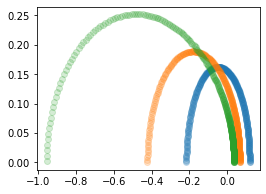

In [13]:
theta = np.arange(0, np.pi, 0.01)
g = np.arange(0.1, 0.51, 0.2)
p = np.zeros(shape=(len(g), len(theta)))
for i in range(len(g)):
    p[i,:] = (1-g[i]*g[i])/((1+g[i]*g[i]+2*g[i]*np.cos(theta))**(3/2))/(2*np.pi) # 2*pi*p(theta)
    
px = p*np.cos(theta)
py = p*np.sin(theta)
    
plt.figure(figsize=(4, 3))
for i in range(len(g)):
    plt.scatter(px[i,:], py[i,:], alpha=0.2)
plt.show()


Draw the curve of $2\pi p(\theta) sin(\theta)$.

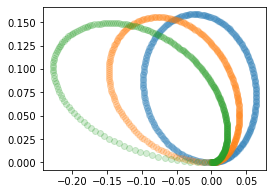

In [14]:
ps = p*np.sin(theta)
px = ps*np.cos(theta)
py = ps*np.sin(theta)
    
plt.figure(figsize=(4, 3))
for i in range(len(g)):
    plt.scatter(px[i,:], py[i,:], alpha=0.2)
plt.show()

## (2) Sample H-G distribution

In [15]:
def generate_HG_data(g, n_samples):
    x_data = np.random.uniform(0, 1, n_samples)
    y_data = (1+g**2 - ((1-g**2)/(1-g+2*g*x_data))**2)/(2*g)
    return x_data, y_data
    
g = 0.9
n_samples = 1000
x_data, y_data = generate_HG_data(g, n_samples)

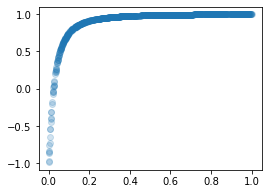

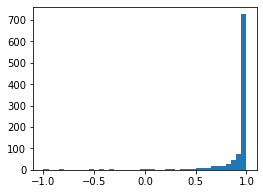

In [16]:
plt.figure(figsize=(4, 3))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()
plt.figure(figsize=(4, 3))
plt.hist(y_data,bins=np.arange(-1,1.01,0.05))
plt.show()

Since $\mu=\cos(\theta)$, we can also show the histogram of $\theta$.

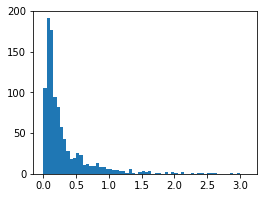

In [17]:
theta = np.arccos(y_data)
plt.figure(figsize=(4, 3))
plt.hist(theta,bins=np.arange(0,np.pi,0.05))
plt.show()

## (3) Learning H-G function with a MLP

We will use the sampled data to train a neural network with one hidden layer to act as the H-G function. Given a random number that follows the uniform distribution of $[0,1]$, the neural network will produce an output that follows an H-G distribution, with the parameter $g$ defined by the training data. 

This neural network is described by the following equation:

$y_{pred}(x) = w_{out} \tanh( w_{in} x + b_{in}) + b_{out}$

- $y_{pred}(x)$: this function $y_{pred}$ takes $x$ as input.
- $w_{in}, w_{out}$: weights for the input and output layers.
- $b_{in}, b_{out}$: biases for the input and output layers.
- $\tanh$: a nonlinear activation function.

Let's create this network using 20 hidden nodes.

In [18]:
n_input = 1
n_hidden = 20
n_output = 1

# create the network (also called a "model" of the data)
network = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

To train the network we must define a loss function. Also called a "cost function", this is a description of what counts as "better" or "worse" results, and allows us to modify the network to achieve the best results.

We will use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss function.

In [19]:
loss_fn = nn.MSELoss()

We also need to pick an optimizer. Optimizers use the loss to determine which parameters in the network should be changed, and how much.

We will use the [RMSprop](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) optimizer, which happens to work well for this problem.

In [20]:
optimizer = torch.optim.RMSprop(network.parameters())

Now let's move our data from numpy to PyTorch. This requires:

1. Converting the data from `np.float64` (numpy default) to `np.float32` (Torch default).
2. Reshaping the data from `(n_samples)` to `(n_samples, n_input)`. Typically the first dimension is your batch size, but here we are processing all the samples in one batch.
3. Convert from a numpy array to a PyTorch tensor.
4. Initialize an input and output `Variable` that we can feed the x and y tensors.

We will use this naming convention:

- numpy arrays `x_data`
- PyTorch tensors `x_tensor`
- PyTorch Variables `x_variable`

In [21]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(x_data).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_data).reshape(n_samples, n_input))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

Now let's define a training loop. It will use the optimizer to minimize the loss function by modifying the network's parameters.

In [22]:
def train(model, input, groundtruth, optimizer):
    for epoch in range(3001):
        pred = model(input) # make a prediction
        loss = loss_fn(pred, groundtruth) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(epoch, loss.data.item())

train(network, x_variable, y_variable, optimizer)

0 0.431562602519989
300 0.02474200911819935
600 0.01596897840499878
900 0.00976400263607502
1200 0.005698631517589092
1500 0.005199100356549025
1800 0.003993609920144081
2100 0.001569003565236926
2400 0.0033128014765679836
2700 0.0009332825429737568
3000 0.0007418280001729727


Let's see how the neural network performs by processing some evenly spaced samples.

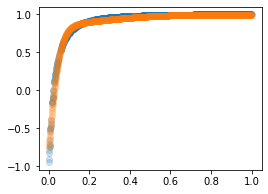

In [100]:
# evenly spaced samples from 0 to 1
x_test_data = np.linspace(0, 1, n_samples)

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(4, 3))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

The network fits the data generated by H-G function directly quite well, as expected. By this way, we say that the neural network is equivalent to a H_G function.

## (4) Estimate the parameter $g$ of H-G function using a MLP

Try to use a MLP to estimate the parameter $g$ of H-G function. In this case, the input of MLP is a sample from H-G distribution and the output of MLP is the prediction of $g$.

In [23]:
g = np.arange(0.5, 0.96, 0.01)
n_samples = 1000
x_data = np.zeros(shape=(len(g), n_samples))
y_data = np.zeros(shape=(len(g), n_samples))
g_data = np.zeros(shape=(len(g), n_samples))
for i in range(len(g)):
    x_data[i,:], y_data[i,:] = generate_HG_data(g[i], n_samples)    # only y_data is used to regress g
    g_data[i,:] = g[i]  # the ground-truth of g

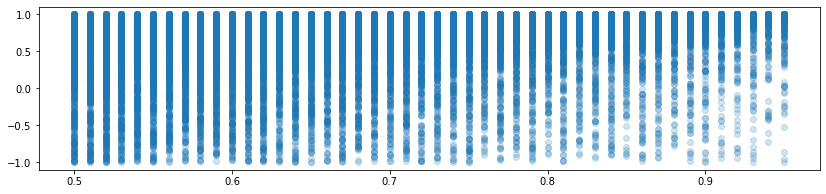

In [24]:
# Show the training data. It can be seen that there are multiple g values corresonding with the same input value (y). 
plt.figure(figsize=(14, 3))
plt.scatter(g_data.reshape(-1)[:46000], y_data.reshape(-1)[:46000], alpha=0.2)
plt.show()

In [26]:
# If we use the same method to fit this data, it won't work well because the network can't output multiple values for each input. Because we used mean squared error loss, the network will try to output the average output value for each input.
y_tensor = torch.from_numpy(np.float32(y_data).reshape(len(g)*n_samples, n_input))
g_tensor = torch.from_numpy(np.float32(g_data).reshape(len(g)*n_samples, n_input))
y_variable = Variable(y_tensor)
g_variable = Variable(g_tensor, requires_grad=False)

train(network, y_variable, g_variable, optimizer)

0 0.0345752127468586
300 0.014587781392037868
600 0.015963468700647354
900 0.014227870851755142
1200 0.014187850058078766
1500 0.02619374915957451
1800 0.01412294339388609
2100 0.014184338040649891
2400 0.01646316610276699
2700 0.01399252563714981
3000 0.014408324845135212


In [27]:
# The problem can not be solved even if we use a more deep network and other training techniques.
# Define a three layers network.
# By convention, the input layer is not counted as a layer in the MLP.

n_input = 1
n_hidden1 = 20
n_hidden2 = 10
n_output = 1

# create the network (also called a "model" of the data)
network2 = nn.Sequential(nn.Linear(n_input, n_hidden1),
                        # nn.BatchNorm1d(n_hidden1),
                        nn.ELU(),
                        nn.Linear(n_hidden1, n_hidden2),
                        #nn.BatchNorm1d(n_hidden2),
                        nn.ELU(),
                        nn.Linear(n_hidden2, n_output))

# training options
loss_fn = nn.MSELoss()  # MSE loss function
optimizer2 = torch.optim.SGD(network2.parameters(), lr=1e-4, weight_decay=1e-3, momentum=0.9)

train(network2, y_variable, g_variable, optimizer2)

0 0.6556789875030518
300 0.018702268600463867
600 0.01777009107172489
900 0.017231982201337814
1200 0.016894793137907982
1500 0.016681978479027748
1800 0.01654624380171299
2100 0.016458310186862946
2400 0.016400035470724106
2700 0.016360173001885414
3000 0.016331758350133896


About the selection of optimizer, see [here](https://blog.csdn.net/qq_36589234/article/details/89330342)

Test the new model

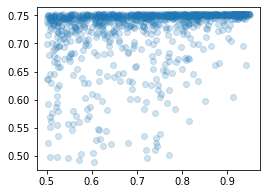

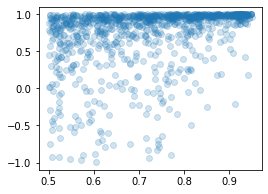

In [28]:
def test2():
    n_samples = 1000
    g = np.random.uniform(0.5, 0.95, n_samples)
    x_test_data = np.zeros(n_samples)
    y_test_data = np.zeros(n_samples)
    for i in range(len(g)):
        x_test_data[i], y_test_data[i] = generate_HG_data(g[i], 1)

    # change data shape, move from numpy to torch
    y_test_tensor = torch.from_numpy(np.float32(y_test_data).reshape(n_samples, n_input))
    y_test_variable = Variable(y_test_tensor)
    g_pred_variable = network2(y_test_variable)

    # move from torch back to numpy
    g_pred = g_pred_variable.data.numpy().reshape(-1)

    # plot the original data and the test data
    plt.figure(figsize=(4, 3))
    plt.scatter(g, g_pred, alpha=0.2)
    plt.show()

    plt.figure(figsize=(4, 3))
    plt.scatter(g, y_test_data, alpha=0.2)
    plt.show()

test2()

## (5) Using multiple samples to estimate the parameter $g$ of H-G function

A neural network cannot learn the distribution by looking at a single sample. It needs to look at multiple samples at a time to find the distribution.

In [29]:
g = np.arange(0.5, 0.96, 0.01)
# for each g value, generate 1000 samples and use the histogram (100 bins) as the one feature
n_samples = 1000
n_bins = 100
# for each g value, generate 1000 train samples. 
n_trainNum = 100

y_data = np.zeros(shape=(len(g)*n_trainNum, n_bins))
g_data = np.zeros(shape=(len(g)*n_trainNum, 1))
for i in range(len(g)):
    for j in range(n_trainNum):
        x, y = generate_HG_data(g[i], n_samples)    # sample the distribution
        h, bins = np.histogram(y, bins=n_bins, range=(-1, 1))
        h = (h-np.min(h))/(np.max(h)-np.min(h))     # normalize the histogram
    
        y_data[i*n_trainNum+j,:] = h     # using histogram as the training data
        g_data[i*n_trainNum+j] = g[i]    # the ground-truth of g

In [30]:
# define a new network
n_input = n_bins
n_hidden1 = 20
n_hidden2 = 10
n_output = 1

# create the network (also called a "model" of the data)
network3 = nn.Sequential(nn.Linear(n_input, n_hidden1),
                        # nn.BatchNorm1d(n_hidden1),
                        nn.ELU(),
                        nn.Linear(n_hidden1, n_hidden2),
                        #nn.BatchNorm1d(n_hidden2),
                        nn.ELU(),
                        nn.Linear(n_hidden2, n_output))

# training options
loss_fn = nn.MSELoss()  # MSE loss function
optimizer3 = torch.optim.SGD(network3.parameters(), lr=1e-4, weight_decay=1e-3, momentum=0.9)

In [31]:
# organize the training data for pytorch
y_tensor = torch.from_numpy(np.float32(y_data))
g_tensor = torch.from_numpy(np.float32(g_data))
y_variable = Variable(y_tensor)
g_variable = Variable(g_tensor, requires_grad=False)

In [32]:
train(network3, y_variable, g_variable, optimizer3)

0 0.2624307870864868
300 0.053296998143196106
600 0.028319327160716057
900 0.024675466120243073
1200 0.02301921509206295
1500 0.021641187369823456
1800 0.02037975750863552
2100 0.01920432224869728
2400 0.01809893734753132
2700 0.017051834613084793
3000 0.016053905710577965


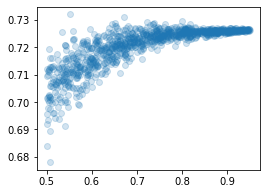

In [34]:
def test3():
    n_samples = 1000
    g = np.random.uniform(0.5, 0.95, n_samples)
    
    y_test_data = np.zeros(shape=(len(g), n_bins))
    for i in range(len(g)):
        x, y = generate_HG_data(g[i], n_samples)    # sample the distribution
        h, bins = np.histogram(y, bins=n_bins, range=(-1, 1))
        h = (h-np.min(h))/(np.max(h)-np.min(h))     # normalize the histogram
        y_test_data[i,:] = h     # using histogram as the training data
    
    # change data shape, move from numpy to torch
    y_test_tensor = torch.from_numpy(np.float32(y_test_data))
    y_test_variable = Variable(y_test_tensor)
    g_pred_variable = network3(y_test_variable)

    # move from torch back to numpy
    g_pred = g_pred_variable.data.numpy().reshape(-1)

    # plot the original data and the test data
    plt.figure(figsize=(4, 3))
    plt.scatter(g, g_pred, alpha=0.2)
    plt.show()

test3()

[More on creating MLP with pytorch](https://www.machinecurve.com/index.php/2021/01/26/creating-a-multilayer-perceptron-with-pytorch-and-lightning/)